<a href="https://colab.research.google.com/github/wendikardian/exercise_machine_learning/blob/main/nlp_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd

data = pd.read_csv("test.csv", on_bad_lines='skip')


In [43]:
data.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

<Axes: xlabel='Class Index', ylabel='count'>

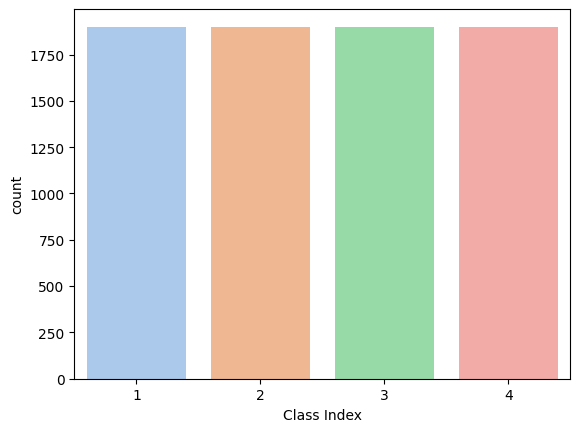

In [44]:
import seaborn as sns
sns.countplot(x='Class Index', data=data, palette='pastel')


In [45]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

data.loc[:,'Description'] = data.loc[:,'Description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data.loc[:,'Description'] = data.loc[:,'Description'].apply(lambda word: re.sub('[^a-z A-Z 0-9-]+', '', word))

stop_words = stopwords.words('english')
data.loc[:,'Description'] = data.loc[:,'Description'].apply(lambda word: " ".join(word for word in word.split() if word not in stop_words))

stemmer = PorterStemmer()
data.loc[:,'Description'] = data.loc[:,'Description'].apply(lambda word: " ".join(stemmer.stem(word) for word in word.split()))
data.head()["Description"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    union repres worker turner newal say disappoin...
1    spacecom - toronto canada -- secondteam rocket...
2    ap - compani found chemistri research univers ...
3    ap - bare dawn mike fitzpatrick start shift bl...
4    ap - southern california smog-fight agenc went...
Name: Description, dtype: object

In [46]:
category = pd.get_dummies(data['Class Index'])
data_concat = pd.concat([data, category], axis = 1)
data_concat

,Class Index,Title,Description,1,2,3,4
0,3,Fears for T N pension after talks,union repres worker turner newal say disappoin...,0,0,1,0
1,4,The Race is On: Second Private Team Sets Launc...,spacecom - toronto canada -- secondteam rocket...,0,0,0,1
2,4,Ky. Company Wins Grant to Study Peptides (AP),ap - compani found chemistri research univers ...,0,0,0,1
3,4,Prediction Unit Helps Forecast Wildfires (AP),ap - bare dawn mike fitzpatrick start shift bl...,0,0,0,1
4,4,Calif. Aims to Limit Farm-Related Smog (AP),ap - southern california smog-fight agenc went...,0,0,0,1
...,...,...,...,...,...,...,...
7595,1,Around the world,ukrainian presidenti candid viktor yushchenko ...,1,0,0,0
7596,2,Void is filled with Clement,suppli attract pitch option dwindl daili -- lo...,0,1,0,0
7597,2,Martinez leaves bitter,like roger clemen almost exactli eight year ea...,0,1,0,0
7598,3,5 of arthritis patients in Singapore take Bext...,singapor doctor unit state warn painkil bextra...,0,0,1,0


In [47]:
desc = data_concat['Description'].values
label = data_concat[[1,2,3,4]].values

In [48]:
desc

array(['union repres worker turner newal say disappoint talk stricken parent firm feder mogul',
       'spacecom - toronto canada -- secondteam rocket compet 3610 million ansari x prize contest forpriv fund suborbit space flight offici announc firstlaunch date man rocket',
       'ap - compani found chemistri research univers louisvil grant develop method produc better peptid short chain amino acid build block protein',
       ...,
       'like roger clemen almost exactli eight year earlier pedro martinez left red sox appar bitter way treat manag',
       'singapor doctor unit state warn painkil bextra celebrex may link major cardiovascular problem prescrib',
       'ebay plan buy apart home rental servic rentcom 415 million ad alreadi exhaust breadth offer'],
      dtype=object)

In [49]:
label

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [50]:
from sklearn.model_selection import train_test_split

desc_train, desc_test, label_train, label_test = train_test_split(desc, label, test_size=0.2, shuffle=True)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=3000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')


tokenizer.fit_on_texts(desc_train)
tokenizer.fit_on_texts(desc_test)


sequence_train = tokenizer.texts_to_sequences(desc_train)
sequence_test = tokenizer.texts_to_sequences(desc_test)

padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=3000, output_dim=64),
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


In [53]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9:
            self.model.stop_training = True
            print("Accuracy train / val has reached > 90%")

callbacks = MyCallback()

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = model.fit(padded_train, label_train, epochs=15, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks], validation_steps=30)


Epoch 1/15
190/190 - 31s - loss: 1.0282 - accuracy: 0.5577 - val_loss: 0.5708 - val_accuracy: 0.7914 - 31s/epoch - 164ms/step
Epoch 2/15
190/190 - 25s - loss: 0.4599 - accuracy: 0.8416 - val_loss: 0.4748 - val_accuracy: 0.8375 - 25s/epoch - 132ms/step
Epoch 3/15
190/190 - 22s - loss: 0.3778 - accuracy: 0.8717 - val_loss: 0.4834 - val_accuracy: 0.8336 - 22s/epoch - 117ms/step
Epoch 4/15
190/190 - 23s - loss: 0.3191 - accuracy: 0.8852 - val_loss: 0.5156 - val_accuracy: 0.8336 - 23s/epoch - 120ms/step
Epoch 5/15
190/190 - 24s - loss: 0.2767 - accuracy: 0.9056 - val_loss: 0.5732 - val_accuracy: 0.8342 - 24s/epoch - 124ms/step
Epoch 6/15
190/190 - 24s - loss: 0.2552 - accuracy: 0.9092 - val_loss: 0.5973 - val_accuracy: 0.8178 - 24s/epoch - 124ms/step
Epoch 7/15
190/190 - 23s - loss: 0.2257 - accuracy: 0.9202 - val_loss: 0.6257 - val_accuracy: 0.8151 - 23s/epoch - 121ms/step
Epoch 8/15
190/190 - 25s - loss: 0.2013 - accuracy: 0.9303 - val_loss: 0.6964 - val_accuracy: 0.8086 - 25s/epoch - 130

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
